In [1]:
import os
from glob import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from nptdms import TdmsFile as TF
import datetime
from datetime import timedelta as td
import time
%matplotlib inline



class MHDPlots(object):
    def __init__(self, ):
        self.samples = []
        self.pathnames = []
        self.imports = {}
        self.data = {}
        self.tracks = {}
        
        ##samples is a list of strings, the samples names
        ##pathnames is the full pathnames to get to each tdms file (there maybe multiple tdms files associated to different samples)
        ##imports is a dictionary, using the pathnames as the word and the imported tdms file as its definition
        ##           this step is necessary as importing the data is the longest process, but pulling data to arrays is almost immediate
        ##data is a dictionary, using the pathnames as the word and a 2D array with all data stored, useful for plotting
        ##tracks is meant to track what data has already been pulled from the imported file, and track what position in the data array certain data are
        ##           tracks uses channelnames as the word and an integer as its definition
        
        
    def set_path(self, path):
        samples = self.samples
        pathnames = self.pathnames
        for file in os.listdir(path):
            samples = np.append(samples, str(file))
        for sample in samples:
            this = glob(path+"\\"+sample+"\\*_together.tdms")
            pathnames = np.append(pathnames, this)
        
        self.pathnames = pathnames    
        self.samples = samples
        return
    
        ##sets the path to the main folder with subfolders and tdms files in those subfolders
        ##uses the names of folders as samples and filepaths as pathnames
    
    def importdata(self, string):
        #Will import all data in the defined file path with substring input
        pathnames = self.pathnames
        imports = self.imports
        for pathname in pathnames:
            if string in pathname:
                imports[pathname] = TF(pathname)
        
        self.imports = imports
        self.get_times()
        #self.createref()
        return
    
        ##imports tdms files that contain the given string. for example: the molybdenum rod experiments had 9mm, 11mm, and 13mm runs
        ##folder and file paths were organized as such
        ##runs get_times(), makes it easier to stack arrays of data and line them up with time
        
    def createref(self,):
        dic = {}
        for impor in self.imports:
            file = self.imports[impor]
            break
        groups = file.groups()
        for group in groups:
            dic[group] = []
            for channel in file.group_channels(group):
                channelname = channel.channel
                dic[group] = np.append(dic[group], channelname)
        return dic
    
    def get_times(self, ):
        imports = self.imports
        data = self.data
        tracks = self.tracks
        tracks["Time"] = 0
        for string in imports:
            file = imports[string]
            data[string] = file.object("Global", "Time").data
            
        self.data = data
        self.tracks = tracks
        return
        
        ##Fills the data dictionary with initial arrays of time, to stack with other data in future
    
    def get_motor(self,):
        motortrack = "motor A"
        #group = "Motors"
        self.get_data(motortrack)
        return
    
        ##Calls motor position from motor A for current set up
        
    def get_tc(self, ):
        tctrack = "T_Sample (Arith. Mean)"
        self.get_data(tctrack)
        ##run get data with thermocouple data from the sample holder    
        return
    
    def get_blackbody(self,):
        tracks = self.tracks
        data = self.data
        
        ct1 = "Color Temp 2-3"
        ct2 = "Color Temp 1-3"
        ct3 = "Color Temp 1-2"
        ctavg = "Avg Color Temp"
        self.get_data(ct1)
        self.get_data(ct2)
        self.get_data(ct3)
        
        tracks["Color Temp Avg."] = len(tracks)
        
        for sample in data:
            temp1 = data[sample][tracks[ct1]]
            temp2 = data[sample][tracks[ct2]]
            temp3 = data[sample][tracks[ct3]]
            ctavg = np.mean(np.vstack((temp1,temp2,temp3)),0)
            self.store_data(sample, ctavg)
            
        self.tracks = tracks
        return
        ##gets all two color temperatures and stores them, then calculates the averages and stores that as well
    
    def get_custom(self, channelname):
        tctrack = channelname
        self.get_data(tctrack)
        return
        ##allows you to get data from a custom channel, given an input channel name
    
    
    def get_data(self, track, group=10):
        data = self.data
        imports = self.imports
        tracks = self.tracks
        
        if track not in tracks:     
            tracks[track] = len(tracks)
            for string in imports:
                file = imports[string]
                if group == 10:
                    groups = file.groups()
                    for item in groups:
                        channels = file.group_channels(item)
                        for channel in channels:
                            if track == channel.channel:
                                subdata = channel.data
                else:
                    subdata = file.object(group,track).data
                    
                self.store_data(string, subdata)
        else:
            print("Error: trying to store duplicate data")
        
        self.tracks = tracks
        return
        
        ##searches all groups for a channel with the channelname
        ##gets data from this channel, runs store_data() to update the respective data array
    
    def store_data(self, string, array):
        data = self.data
        
        length = len(np.transpose(data[string]))
        if len(array) != length:
            array = self.resize(array, length)
        data[string] = np.vstack((data[string], array))
        
        self.data = data
        return
        
        ##as implied, stores data. stacks the array with time, updates the data dictionary, and stores data position in tracks
        ##the else statement prevents the data arrays from storing duplicate data
    
    def align(self, channel="motor A"):
        data = self.data
        tracks = self.tracks
        track = "Init Time"
        
        if track not in tracks:
            for sample in data:
                time = data[sample][tracks["Time"]]
                motor = data[sample][tracks[channel]]
                start = np.where(motor[1:]-motor[:-1]>.2)
                start = start[0][1]
                timerel = np.zeros_like(time)
                for i, val in enumerate(time):
                    timerel[i] = (time[i]-time[start]).total_seconds()
                    if np.isclose(timerel[i],2000, rtol=.0001):
                        self.stop = i
                    if np.isclose(timerel[i],0,rtol=.0001):
                        self.start = i
                self.store_data(sample, timerel)
                
            tracks["Time"] = len(tracks)
            tracks[track] = 0
        self.tracks = tracks
        return
        ##Creates a relative time array, for comparing different samples, and aligns the start time of burning the sample
        ##    with the motors position
        ##In future experiments, the align function might be used with other channels, and is anticipated to be made more general

    def plot_tc(self, rods="all"):
        data = self.data
        
        if rods == "all":
            rods = self.samples
        
        for rod in rods:
            for sample in data:
                if rod in sample:
                    print(sample)
                    self.plot_sometc(sample)
        plt.title("Themocouple Temp. ")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        return
        
    def plot_alltc(self,):
        data = self.data
        
        for rod in data:
            self.plot_sometc(rod)
        
        return

    def plot_sometc(self, rod):
        data = self.data
        tracks = self.tracks
        track = "T_Sample (Arith. Mean)"
        plt.ylabel("Temperatue (C)")
        plt.xlabel("Time (s)")
        for sample in self.samples:
            if sample in rod:
                name = sample
        plt.plot(data[rod][tracks['Time']], data[rod][tracks[track]], label = name)
        return
    
    def resize(self, arr, length):
        if len(arr)>length:
            arr = arr[1:]
        elif len(arr)<length:
            arr = np.append(arr, 0)
        else:
            print("error")
        return arr   

In [2]:
a = MHDPlots()
a.set_path("D:\\Data\\MolyRod")

In [3]:
starttime = time.time()
a.importdata("13mm_together.tdms")
a.get_motor()
a.get_tc()
a.get_blackbody()
runtime = time.time()-starttime
print(runtime)

320.72285652160645


In [111]:

#savetime = a.imports
#a.imports
a.imports=savetime
a.get_times()

In [69]:
a.align()


In [99]:
a.data["D:\\Data\\MolyRod\\MolyA\\13mm_together.tdms"]


[datetime.datetime(2018, 1, 4, 18, 46, 47, 440175, tzinfo=<UTC>),
 datetime.datetime(2018, 1, 4, 18, 46, 47, 720175, tzinfo=<UTC>),
 datetime.datetime(2018, 1, 4, 18, 46, 47, 991175, tzinfo=<UTC>),
 datetime.datetime(2018, 1, 4, 18, 46, 48, 259175, tzinfo=<UTC>),
 datetime.datetime(2018, 1, 4, 18, 46, 48, 552175, tzinfo=<UTC>),
 datetime.datetime(2018, 1, 4, 18, 46, 48, 821175, tzinfo=<UTC>),
 datetime.datetime(2018, 1, 4, 18, 46, 49, 88175, tzinfo=<UTC>),
 datetime.datetime(2018, 1, 4, 18, 46, 49, 381175, tzinfo=<UTC>),
 datetime.datetime(2018, 1, 4, 18, 46, 49, 654175, tzinfo=<UTC>),
 datetime.datetime(2018, 1, 4, 18, 46, 49, 953175, tzinfo=<UTC>),
 datetime.datetime(2018, 1, 4, 18, 46, 50, 219175, tzinfo=<UTC>),
 datetime.datetime(2018, 1, 4, 18, 46, 50, 487175, tzinfo=<UTC>),
 datetime.datetime(2018, 1, 4, 18, 46, 50, 762175, tzinfo=<UTC>),
 datetime.datetime(2018, 1, 4, 18, 46, 51, 32175, tzinfo=<UTC>),
 datetime.datetime(2018, 1, 4, 18, 46, 51, 300175, tzinfo=<UTC>),
 datetime.da

D:\Data\MolyRod\MolyA\13mm_together.tdms
D:\Data\MolyRod\MolyB\13mm_together.tdms
D:\Data\MolyRod\MolyC\13mm_together.tdms
D:\Data\MolyRod\MolyD\13mm_together.tdms
D:\Data\MolyRod\MolyE\13mm_together.tdms
D:\Data\MolyRod\MolyF\13mm_together.tdms


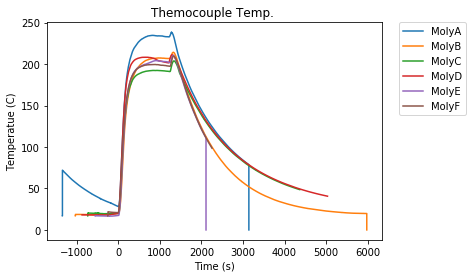

In [30]:
a.plot_tc()

In [365]:
a.pathnames

array(['D:\\Data\\MolyRod\\MolyA\\11mm_together.tdms',
       'D:\\Data\\MolyRod\\MolyA\\13mm_together.tdms',
       'D:\\Data\\MolyRod\\MolyA\\9mm_together.tdms',
       'D:\\Data\\MolyRod\\MolyB\\13mm_together.tdms',
       'D:\\Data\\MolyRod\\MolyB\\9mm_together.tdms',
       'D:\\Data\\MolyRod\\MolyC\\11mm_together.tdms',
       'D:\\Data\\MolyRod\\MolyC\\13mm_together.tdms',
       'D:\\Data\\MolyRod\\MolyC\\9mm_together.tdms',
       'D:\\Data\\MolyRod\\MolyD\\11mm_together.tdms',
       'D:\\Data\\MolyRod\\MolyD\\13mm_together.tdms',
       'D:\\Data\\MolyRod\\MolyD\\9mm_together.tdms',
       'D:\\Data\\MolyRod\\MolyE\\11mm_together.tdms',
       'D:\\Data\\MolyRod\\MolyE\\13mm_together.tdms',
       'D:\\Data\\MolyRod\\MolyE\\9mm_together.tdms',
       'D:\\Data\\MolyRod\\MolyF\\11mm_together.tdms',
       'D:\\Data\\MolyRod\\MolyF\\13mm_together.tdms',
       'D:\\Data\\MolyRod\\MolyF\\9mm_together.tdms'],
      dtype='<U40')

In [70]:
group = 0

In [71]:
group == 0

True

In [4]:
##Original structure scans each file individually for specific channel to import data,
##    new structure creates a dictionary to refer to, cuts time of get_data() (for 4 data calls) from 30 seconds to .5, but adds 20 seconds
##    to importdata()
import os
from glob import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from nptdms import TdmsFile as TF
import datetime
from datetime import timedelta as td
import time
%matplotlib inline



class MHDPlots1(object):
    def __init__(self, ):
        self.samples = []
        self.pathnames = []
        self.imports = {}
        self.data = {}
        self.tracks = {}
        
        ##samples is a list of strings, the samples names
        ##pathnames is the full pathnames to get to each tdms file (there maybe multiple tdms files associated to different samples)
        ##imports is a dictionary, using the pathnames as the word and the imported tdms file as its definition
        ##           this step is necessary as importing the data is the longest process, but pulling data to arrays is almost immediate
        ##data is a dictionary, using the pathnames as the word and a 2D array with all data stored, useful for plotting
        ##tracks is meant to track what data has already been pulled from the imported file, and track what position in the data array certain data are
        ##           tracks uses channelnames as the word and an integer as its definition
        
        
    def set_path(self, path):
        samples = self.samples
        pathnames = self.pathnames
        for file in os.listdir(path):
            samples = np.append(samples, str(file))
        for sample in samples:
            this = glob(path+"\\"+sample+"\\*_together.tdms")
            pathnames = np.append(pathnames, this)
        
        self.pathnames = pathnames    
        self.samples = samples
        return
    
        ##sets the path to the main folder with subfolders and tdms files in those subfolders
        ##uses the names of folders as samples and filepaths as pathnames
    
    def import_data(self, string):
        #Will import all data in the defined file path with substring input
        pathnames = self.pathnames
        imports = self.imports
        for pathname in pathnames:
            if string in pathname:
                imports[pathname] = TF(pathname)
        
        self.imports = imports
        self.get_times()
        self.createref()
        return
    
        ##imports tdms files that contain the given string. for example: the molybdenum rod experiments had 9mm, 11mm, and 13mm runs
        ##folder and file paths were organized as such
        ##runs get_times(), makes it easier to stack arrays of data and line them up with time
        
    def createref(self,):
        dic = {}
        for impor in self.imports:
            file = self.imports[impor]
            break
        groups = file.groups()
        for group in groups:
            dic[group] = []
            for channel in file.group_channels(group):
                channelname = channel.channel
                dic[group] = np.append(dic[group], channelname)
        self.groups = dic
        return
    
    def get_times(self, ):
        imports = self.imports
        data = self.data
        tracks = self.tracks
        tracks["Time"] = 0
        for string in imports:
            file = imports[string]
            data[string] = file.object("Global", "Time").data
            
        self.data = data
        self.tracks = tracks
        return
        
        ##Fills the data dictionary with initial arrays of time, to stack with other data in future
    
    def get_motor(self,):
        motortrack = "motor A"
        #group = "Motors"
        self.get_data(motortrack)
        return
    
        ##Calls motor position from motor A for current set up
        
    def get_tc(self, ):
        tctrack = "T_Sample (Arith. Mean)"
        self.get_data(tctrack)
        ##run get data with thermocouple data from the sample holder    
        return
    
    def get_blackbody(self,):
        tracks = self.tracks
        data = self.data
        
        ct1 = "Color Temp 2-3"
        ct2 = "Color Temp 1-3"
        ct3 = "Color Temp 1-2"
        ctavg = "Avg Color Temp"
        self.get_data(ct1)
        self.get_data(ct2)
        self.get_data(ct3)
        
        tracks["Color Temp Avg."] = len(tracks)
        
        for sample in data:
            temp1 = data[sample][tracks[ct1]]
            temp2 = data[sample][tracks[ct2]]
            temp3 = data[sample][tracks[ct3]]
            ctavg = np.mean(np.vstack((temp1,temp2,temp3)),0)
            self.store_data(sample, ctavg)
            
        self.tracks = tracks
        return
        ##gets all two color temperatures and stores them, then calculates the averages and stores that as well
    
    def get_custom(self, channelname):
        tctrack = channelname
        self.get_data(tctrack)
        return
        ##allows you to get data from a custom channel, given an input channel name
    
    
    def get_data(self, track, group=10):
        data = self.data
        imports = self.imports
        tracks = self.tracks
        groups = self.groups
        
        if track not in tracks:     
            tracks[track] = len(tracks)
            for string in imports:
                file = imports[string]
                if group == 10:
                    for item in groups:
                        if track in groups[item]:
                            group = item
                subdata = file.object(group,track).data    
                self.store_data(string, subdata)
        else:
            print("Error: trying to store duplicate data")
        
        self.tracks = tracks
        return
        
        ##searches all groups for a channel with the channelname
        ##gets data from this channel, runs store_data() to update the respective data array
    
    def store_data(self, string, array):
        data = self.data
        
        length = len(np.transpose(data[string]))
        if len(array) != length:
            array = self.resize(array, length)
        data[string] = np.vstack((data[string], array))
        
        self.data = data
        return
        
        ##as implied, stores data. stacks the array with time, updates the data dictionary, and stores data position in tracks
        ##the else statement prevents the data arrays from storing duplicate data
    
    def align(self, channel="motor A"):
        data = self.data
        tracks = self.tracks
        track = "Init Time"
        
        if track not in tracks:
            for sample in data:
                time = data[sample][tracks["Time"]]
                motor = data[sample][tracks[channel]]
                start = np.where(motor[1:]-motor[:-1]>.2)
                start = start[0][1]
                timerel = np.zeros_like(time)
                for i, val in enumerate(time):
                    timerel[i] = (time[i]-time[start]).total_seconds()
                    if np.isclose(timerel[i],2000, rtol=.0001):
                        self.stop = i
                    if np.isclose(timerel[i],0,rtol=.0001):
                        self.start = i
                self.store_data(sample, timerel)
                
            tracks["Time"] = len(tracks)
            tracks[track] = 0
        self.tracks = tracks
        return
        ##Creates a relative time array, for comparing different samples, and aligns the start time of burning the sample
        ##    with the motors position
        ##In future experiments, the align function might be used with other channels, and is anticipated to be made more general

    def plot_tc(self, rods="all"):
        data = self.data
        
        if rods == "all":
            rods = self.samples
        
        for rod in rods:
            for sample in data:
                if rod in sample:
                    print(sample)
                    self.plot_sometc(sample)
        plt.title("Themocouple Temp. ")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        return
        
    def plot_alltc(self,):
        data = self.data
        
        for rod in data:
            self.plot_sometc(rod)
        
        return

    def plot_sometc(self, rod):
        data = self.data
        tracks = self.tracks
        track = "T_Sample (Arith. Mean)"
        plt.ylabel("Temperatue (C)")
        plt.xlabel("Time (s)")
        for sample in self.samples:
            if sample in rod:
                name = sample
        plt.plot(data[rod][tracks['Time']], data[rod][tracks[track]], label = name)
        return
    
    def resize(self, arr, length):
        if len(arr)>length:
            arr = arr[1:]
        elif len(arr)<length:
            arr = np.append(arr, 0)
        else:
            print("error")
        return arr   

In [5]:
b = MHDPlots1()
b.set_path("D:\\Data\\MolyRod")


In [7]:
start = time.time()
b.importdata("13mm_together.tdms")
b.get_motor()
b.get_tc()
b.get_blackbody()
end = time.time() - start
print(end)

291.30114459991455


In [130]:
b.align()

D:\Data\MolyRod\MolyA\13mm_together.tdms
D:\Data\MolyRod\MolyB\13mm_together.tdms
D:\Data\MolyRod\MolyC\13mm_together.tdms
D:\Data\MolyRod\MolyD\13mm_together.tdms
D:\Data\MolyRod\MolyE\13mm_together.tdms
D:\Data\MolyRod\MolyF\13mm_together.tdms


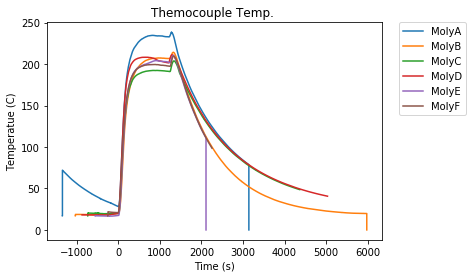

In [131]:
b.plot_tc()